In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
torch. cuda. get_device_name()

cuda


'NVIDIA GeForce RTX 3080 Ti'

In [5]:
import os
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

# read CSV 
def load_labels(csv_path):
    df = pd.read_csv(csv_path, header=None, names=["folder", "label"])
    data = []
    for _, row in df.iterrows():
        image_paths = glob(os.path.join(row["folder"], "*.png"))  
        label = row["label"]
        for img_path in image_paths:
            data.append((img_path, label))
    return data

# define dataset
class MURADataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)


transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

train_data = load_labels("MURA-v1.1/train_labeled_studies.csv")
valid_data = load_labels("MURA-v1.1/valid_labeled_studies.csv")

train_dataset = MURADataset(train_data, transform)
valid_dataset = MURADataset(valid_data, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [2]:
import torchvision.models as models
import torch.nn as nn
from torchvision.models.efficientnet import EfficientNet_B3_Weights


class MURAModel(nn.Module):
    def __init__(self):
        super(MURAModel, self).__init__()
        self.model = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)  
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)  

    def forward(self, x):
        return self.model(x)

model = MURAModel().cuda()


In [4]:
import torch
import torch.optim as optim
import torch.nn.functional as F

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


Epoch [1/20], Loss: 0.4859
Epoch [2/20], Loss: 0.4006
Epoch [3/20], Loss: 0.3322
Epoch [4/20], Loss: 0.2600
Epoch [5/20], Loss: 0.1901
Epoch [6/20], Loss: 0.1398
Epoch [7/20], Loss: 0.1084
Epoch [8/20], Loss: 0.0899
Epoch [9/20], Loss: 0.0764
Epoch [10/20], Loss: 0.0695
Epoch [11/20], Loss: 0.0633
Epoch [12/20], Loss: 0.0533
Epoch [13/20], Loss: 0.0513
Epoch [14/20], Loss: 0.0476
Epoch [15/20], Loss: 0.0438
Epoch [16/20], Loss: 0.0462
Epoch [17/20], Loss: 0.0378
Epoch [18/20], Loss: 0.0383
Epoch [19/20], Loss: 0.0353
Epoch [20/20], Loss: 0.0351


D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24352 (\N{CJK UNIFIED IDEOGRAPH-5F20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from fon

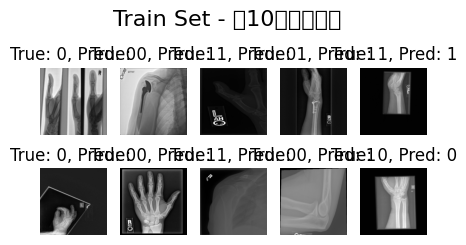

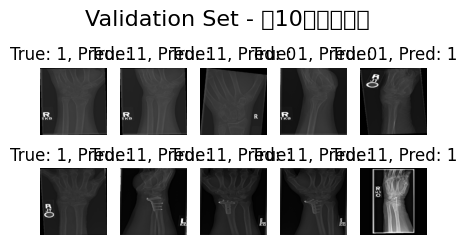

In [ ]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

torch.save(model.state_dict(), "best_model_3d_Mar19.pth")
model.eval()

def visualize_predictions(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            predictions = (probs > 0.5).astype(int)  

            for i in range(len(images)):
                if images_shown >= 10:
                    break
                plt.subplot(4, 5, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy()  
                img = (img - img.min()) / (img.max() - img.min())  

                plt.imshow(img, cmap="gray")
                plt.title(f"True: {int(labels[i].item())}, Pred: {predictions[i][0]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= 10:
                break

    plt.suptitle(f"{dataset_name} - 10", fontsize=16)
    plt.show()

visualize_predictions(train_loader, "Train Set")
visualize_predictions(valid_loader, "Validation Set")


In [4]:
import torch
model = MURAModel().cuda()
model.load_state_dict(torch.load("best_model_3d_Mar19.pth"))
model.eval()
print("load model successful！")

load model successful！


In [9]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

target_layer = model.model.features[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0] 

    def generate_cam(self, input_image):
        input_image = input_image.unsqueeze(0).cuda()
        self.model.zero_grad()
        output = self.model(input_image)  
        output.backward(retain_graph=True) 
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)  
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  
        cam = F.relu(cam)  
        cam = cam.squeeze().cpu().detach().numpy()  
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (224, 224)) 
        return cam

grad_cam = GradCAM(model, target_layer)


D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torch\autograd\graph.py:823: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\cuda\CublasHandlePool.cpp:180.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


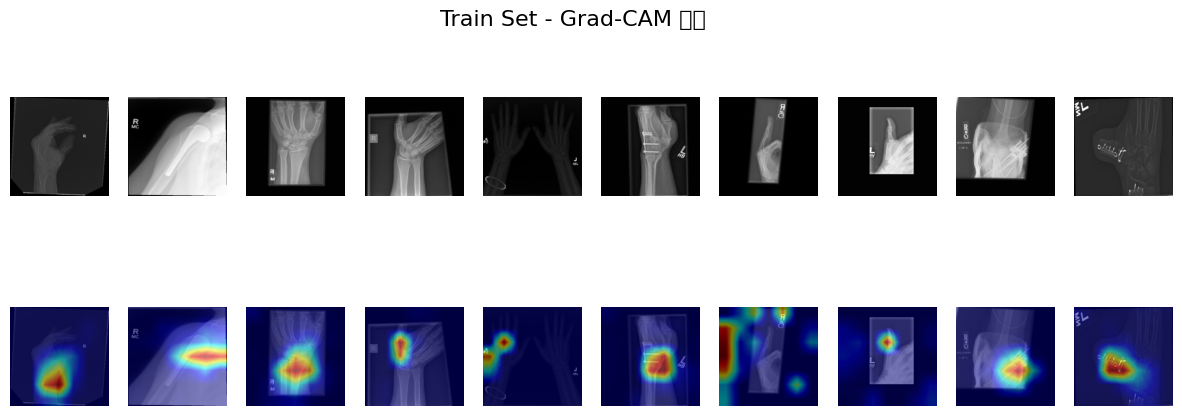

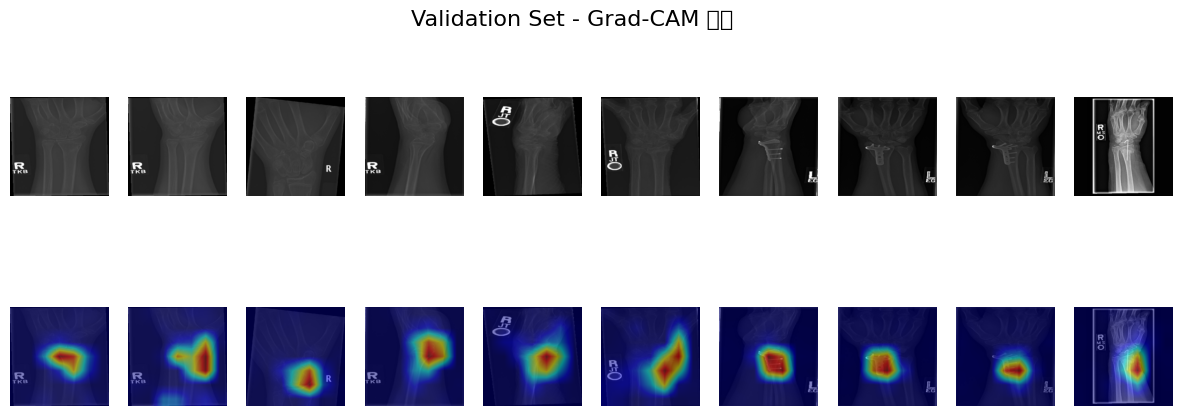

In [10]:
def visualize_cam(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break


            cam = grad_cam.generate_cam(images[i])
            img = images[i].cpu().permute(1, 2, 0).numpy()  
            img = (img - img.min()) / (img.max() - img.min())  
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = (0.5 * heatmap + 0.5 * img * 255).astype(np.uint8)
            plt.subplot(2, 10, images_shown + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")

            plt.subplot(2, 10, images_shown + 11)
            plt.imshow(overlay)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Grad-CAM result", fontsize=16)
    plt.show()

visualize_cam(train_loader, "Train Set")
visualize_cam(valid_loader, "Validation Set")


In [11]:
def generate_bounding_box(cam, box_size=50):
    h, w = cam.shape
    max_idx = np.unravel_index(np.argmax(cam), cam.shape)  
    center_x, center_y = max_idx[1], max_idx[0]  
    half_size = box_size // 2
    x1, y1 = max(0, center_x - half_size), max(0, center_y - half_size)
    x2, y2 = min(w, center_x + half_size), min(h, center_y + half_size)

    return (x1, y1, x2, y2), (center_x, center_y)


Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


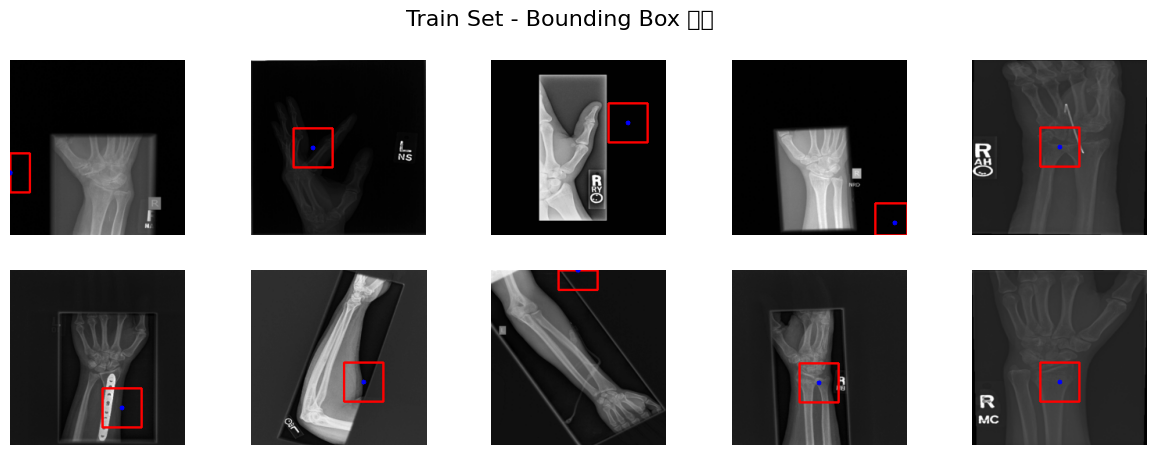

Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


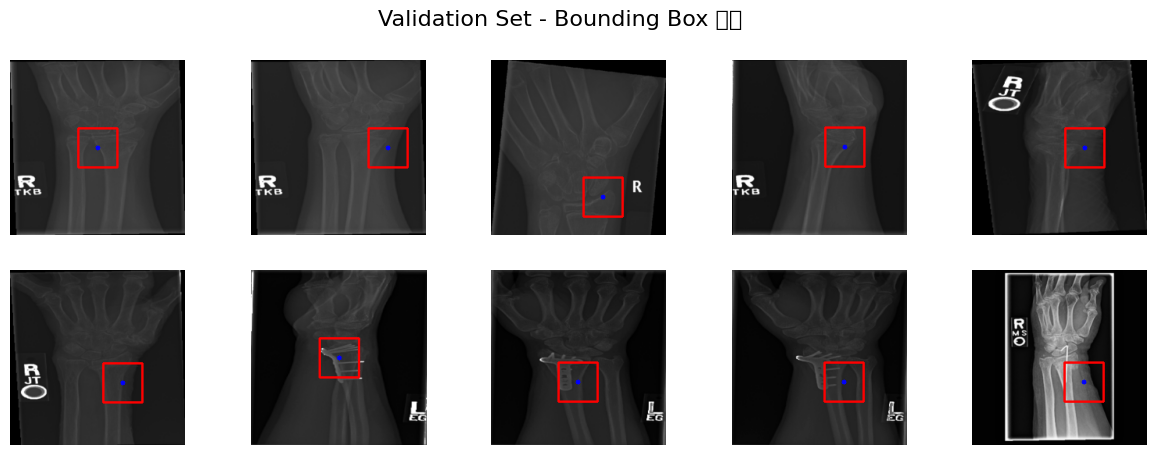

In [12]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(loader, dataset_name, box_size=50):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break
            cam = grad_cam.generate_cam(images[i])
            bbox, center = generate_bounding_box(cam, box_size=box_size)
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  
            img = (img * 255).astype(np.uint8) 
            if img.ndim == 2:  
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[-1] == 1:  
                img = np.repeat(img, 3, axis=-1)
            print(f"Image Shape: {img.shape}, dtype: {img.dtype}")
            img = np.array(img, dtype=np.uint8)  
            x1, y1, x2, y2 = bbox
            img = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (255, 0, 0), 2) 
            img = cv2.circle(img.copy(), center, 3, (0, 0, 255), -1)  
            plt.subplot(2, 5, images_shown + 1)
            plt.imshow(img)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Bounding Box ", fontsize=16)
    plt.show()

visualize_bbox(train_loader, "Train Set")
visualize_bbox(valid_loader, "Validation Set")


In [13]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [14]:
import os
import pandas as pd
from glob import glob
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torchvision.models.efficientnet import EfficientNet_B3_Weights
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch.optim as optim


class MURAModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 1)

    def forward(self, x):
        return self.model(x)


class GradCAMWrapper:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.forward_hook = target_layer.register_forward_hook(self.save_activations)
        self.backward_hook = target_layer.register_backward_hook(self.save_gradients)
    
    def save_activations(self, module, input, output):
        self.activations = output  
    
    def save_gradients(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()
    
    def generate_cam(self, input_tensor):
        self.model.zero_grad()
        with torch.set_grad_enabled(True):
            input_var = input_tensor.unsqueeze(0).requires_grad_(True)
            output = self.model(input_var)
            one_hot = torch.ones_like(output)
            output.backward(gradient=one_hot, retain_graph=False)
            
        weights = self.gradients.mean(dim=[2, 3], keepdim=True)
        cam = (weights * self.activations).sum(1, keepdim=True)
        cam = torch.relu(cam).squeeze()
        cam = cam.detach().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
        cam = cv2.resize(cam, (224, 224))
        return cam

    def __del__(self):
        self.forward_hook.remove()
        self.backward_hook.remove()

def generate_bbox_coordinates(data_list, output_csv):
    model = MURAModel()
    model.load_state_dict(
        torch.load("best_model_3d_Mar19.pth", 
                  map_location='cuda' if torch.cuda.is_available() else 'cpu',
                  weights_only=True)
    )
    model = model.eval().cuda() if torch.cuda.is_available() else model.eval()
    target_layer = model.model.features[-1]
    gradcam = GradCAMWrapper(model, target_layer)
    
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ])
    
    results = []
    for img_path, _ in tqdm(data_list):
        img = Image.open(img_path).convert("RGB")
        tensor_img = transform(img).to(next(model.parameters()).device)
        cam = gradcam.generate_cam(tensor_img) 
        max_idx = np.unravel_index(cam.argmax(), cam.shape)
        center_x, center_y = max_idx[1], max_idx[0]
        box_size = 50
        half_size = box_size // 2
        
        x1 = max(0, center_x - half_size)
        y1 = max(0, center_y - half_size)
        x2 = min(224, center_x + half_size)
        y2 = min(224, center_y + half_size)
        
        results.append([img_path, x1, y1, x2, y2])
    
    pd.DataFrame(results, columns=["path", "x1", "y1", "x2", "y2"]).to_csv(output_csv, index=False)

class BoundingBoxDataset(Dataset):
    def __init__(self, csv_path):
        self.df = pd.read_csv(csv_path)
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        tensor_img = self.transform(img)
        bbox = torch.tensor([row["x1"], row["y1"], row["x2"], row["y2"]], dtype=torch.float32)
        return tensor_img, bbox

class BBoxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.base = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
        self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, 4)
    
    def forward(self, x):
        return self.base(x)


def train_bbox_model():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    train_dataset = BoundingBoxDataset("train_bbox.csv")
    valid_dataset = BoundingBoxDataset("valid_bbox.csv")
    
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=16)

    model = BBoxModel().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    criterion = nn.MSELoss()

    best_loss = float('inf')
    for epoch in range(20):
        model.train()
        train_loss = 0.0
        for imgs, bboxes in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            imgs, bboxes = imgs.to(device), bboxes.to(device)
            
            optimizer.zero_grad()
            outputs = model(imgs)
            loss = criterion(outputs, bboxes)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * imgs.size(0)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for imgs, bboxes in valid_loader:
                imgs, bboxes = imgs.to(device), bboxes.to(device)
                outputs = model(imgs)
                val_loss += criterion(outputs, bboxes).item() * imgs.size(0)
        
        train_loss /= len(train_dataset)
        val_loss /= len(valid_dataset)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
        if val_loss < best_loss:
            best_loss = val_loss
            torch.save(model.state_dict(), "best_bbox_model.pth")

if __name__ == "__main__":
    train_data = load_labels("MURA-v1.1/train_labeled_studies.csv")  
    valid_data = load_labels("MURA-v1.1/valid_labeled_studies.csv")
    generate_bbox_coordinates(train_data, "train_bbox.csv")
    generate_bbox_coordinates(valid_data, "valid_bbox.csv")
    train_bbox_model()

  0%|                                                                                                                 | 0/36808 [00:00<?, ?it/s]D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
Epoch 1: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:00<00:00,  9.58it/s]


Train Loss: 6209.0748 | Val Loss: 2577.5998


Epoch 2: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:59<00:00,  9.63it/s]


Train Loss: 2981.0436 | Val Loss: 2523.2071


Epoch 3: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:59<00:00,  9.60it/s]


Train Loss: 2937.3744 | Val Loss: 2533.0518


Epoch 4: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:59<00:00,  9.62it/s]


Train Loss: 2893.3510 | Val Loss: 2497.8202


Epoch 5: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:58<00:00,  9.64it/s]


Train Loss: 2820.8094 | Val Loss: 2471.5432


Epoch 6: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:58<00:00,  9.65it/s]


Train Loss: 2707.8321 | Val Loss: 2526.7035


Epoch 7: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:57<00:00,  9.71it/s]


Train Loss: 2511.2685 | Val Loss: 2535.7894


Epoch 8: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:59<00:00,  9.59it/s]


Train Loss: 2296.9745 | Val Loss: 2501.5422


Epoch 9: 100%|██████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:58<00:00,  9.64it/s]


Train Loss: 2085.3533 | Val Loss: 2599.9648


Epoch 10: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:58<00:00,  9.64it/s]


Train Loss: 1867.0735 | Val Loss: 2733.1375


Epoch 11: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:10<00:00,  9.19it/s]


Train Loss: 1615.3670 | Val Loss: 2844.5030


Epoch 12: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:09<00:00,  9.23it/s]


Train Loss: 1390.9397 | Val Loss: 2824.3101


Epoch 13: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:08<00:00,  9.25it/s]


Train Loss: 1215.0848 | Val Loss: 2943.3944


Epoch 14: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:08<00:00,  9.26it/s]


Train Loss: 1059.1267 | Val Loss: 3075.2026


Epoch 15: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:02<00:00,  9.47it/s]


Train Loss: 956.0558 | Val Loss: 3057.9664


Epoch 16: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:03<00:00,  9.45it/s]


Train Loss: 858.4800 | Val Loss: 3132.0574


Epoch 17: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [04:02<00:00,  9.48it/s]


Train Loss: 784.7935 | Val Loss: 3049.9101


Epoch 18: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:58<00:00,  9.65it/s]


Train Loss: 724.2653 | Val Loss: 2964.6681


Epoch 19: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:56<00:00,  9.72it/s]


Train Loss: 666.8447 | Val Loss: 3058.5004


Epoch 20: 100%|█████████████████████████████████████████████████████████████████████████████████████████████| 2301/2301 [03:59<00:00,  9.59it/s]


Train Loss: 617.6350 | Val Loss: 3060.1571


In [23]:
torch.save(model.state_dict(), "best_bbox_model2.pth")

Predicted Bounding Boxes:
[[ 18.751593  -49.062485   19.067162   12.919317 ]
 [ -9.687339  -44.35534    -8.974258  -24.147093 ]
 [  6.5905523 -54.096336  -22.452787  -10.908743 ]
 [-21.809013   10.585116   -1.6350499  -6.1529512]]
True Bounding Boxes:
[[ 54.  87. 104. 137.]
 [151.  23. 201.  73.]
 [ 86. 150. 136. 200.]
 [ 87.  55. 137. 105.]]
Predicted Bounding Box Coordinates: (18, -49, 19, 12)
Predicted Bounding Box Coordinates: (-9, -44, -8, -24)
Predicted Bounding Box Coordinates: (6, -54, -22, -10)
Predicted Bounding Box Coordinates: (-21, 10, -1, -6)


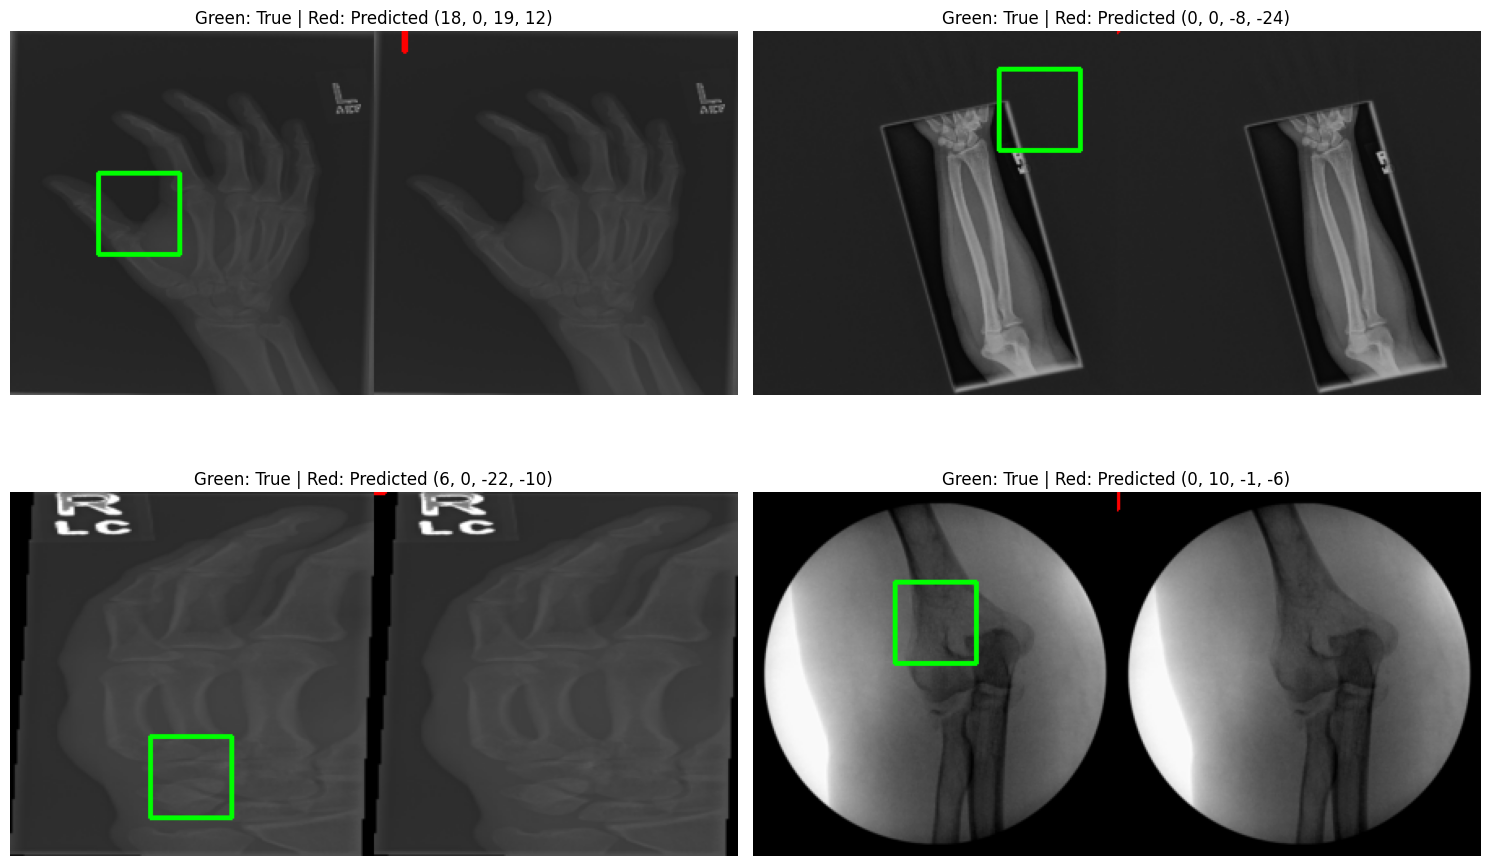

In [50]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import EfficientNet_B3_Weights
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from PIL import Image

def visualize_bbox(model_path="best_bbox_model2.pth"):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    class BBoxModel(nn.Module):
        def __init__(self):
            super().__init__()
            self.base = models.efficientnet_b3(weights=EfficientNet_B3_Weights.DEFAULT)
            self.base.classifier[1] = nn.Linear(self.base.classifier[1].in_features, 4)
        
        def forward(self, x):
            return self.base(x)

    model = BBoxModel().to(device)    
    model.load_state_dict(torch.load(model_path, map_location=device), strict=False)
    model.eval()

    class RawBoundingBoxDataset(Dataset):
        def __init__(self, csv_path):
            self.df = pd.read_csv(csv_path)
            self.transform = transforms.Compose([
                transforms.Resize((224, 224)),  
                transforms.ToTensor()
            ])
        
        def __len__(self):
            return len(self.df)
        
        def __getitem__(self, idx):
            row = self.df.iloc[idx]
            img = Image.open(row["path"]).convert("RGB")
            tensor_img = self.transform(img)
            bbox = torch.tensor([row["x1"], row["y1"], row["x2"], row["y2"]], dtype=torch.float32)
            return tensor_img, bbox
    
    dataset = RawBoundingBoxDataset("valid_bbox.csv")
    loader = DataLoader(dataset, batch_size=4, shuffle=True)
    
    with torch.no_grad():
        imgs, true_bboxes = next(iter(loader))
        imgs = imgs.to(device)
        pred_bboxes = model(imgs).cpu().numpy()
        true_bboxes = true_bboxes.numpy()
        
        # Scale predicted bounding box coordinates to match image dimensions
        img_width, img_height = 224, 224
        pred_bboxes[:, 0] *= img_width
        pred_bboxes[:, 1] *= img_height
        pred_bboxes[:, 2] *= img_width
        pred_bboxes[:, 3] *= img_height
        
        print("Predicted Bounding Boxes:")
        print(pred_bboxes)
        
        print("True Bounding Boxes:")
        print(true_bboxes)
        
        plt.figure(figsize=(15, 10))
        for i in range(4):
            img = imgs[i].cpu().permute(1, 2, 0).numpy()
            img = (img * 255).astype(np.uint8)  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_true = img.copy()
            img_pred = img.copy()
            x1, y1, x2, y2 = true_bboxes[i].astype(int)
            cv2.rectangle(img_true, (x1, y1), (x2, y2), (0, 255, 0), 2)
            px1, py1, px2, py2 = pred_bboxes[i].astype(int)
            
            print(f"Predicted Bounding Box Coordinates: ({px1}, {py1}, {px2}, {py2})")
            
            # Ensure box coordinates are within image boundaries
            px1 = max(0, px1)
            py1 = max(0, py1)
            px2 = min(img.shape[1], px2)
            py2 = min(img.shape[0], py2)
            
            # Draw predicted bounding box
            cv2.rectangle(img_pred, (px1, py1), (px2, py2), (255, 0, 0), 2)
            plt.subplot(2, 2, i+1)
            plt.imshow(np.hstack([img_true, img_pred]))
            plt.title(f"Green: True | Red: Predicted ({px1}, {py1}, {px2}, {py2})")
            plt.axis('off')
        
        plt.tight_layout()
        plt.show()


visualize_bbox()

In [51]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print (device)
torch. cuda. get_device_name()

cuda


'NVIDIA GeForce RTX 3080 Ti'

In [52]:
import os
import pandas as pd
from glob import glob
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch

def load_labels(csv_path):
    df = pd.read_csv(csv_path, header=None, names=["folder", "label"])
    data = []
    for _, row in df.iterrows():
        image_paths = glob(os.path.join(row["folder"], "*.png"))
        label = row["label"]
        for img_path in image_paths:
            data.append((img_path, label))
    return data

class MURADataset(Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) 
])

train_data = load_labels("MURA-v1.1/train_labeled_studies.csv")
valid_data = load_labels("MURA-v1.1/valid_labeled_studies.csv")

train_dataset = MURADataset(train_data, transform)
valid_dataset = MURADataset(valid_data, transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)


In [6]:
import torchvision.models as models
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model_resnet = models.resnet50(pretrained=True)
        num_ftrs = self.model_resnet.fc.in_features
        self.model_resnet.fc = nn.Identity()
        self.fc = nn.Linear(num_ftrs, 1)  # Output layer with one neuron

    def forward(self, x):
        x = self.model_resnet(x)
        out = self.fc(x)
        return out

In [59]:
import torch
import torch.optim as optim
import torch.nn.functional as F

model = MyModel().cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCEWithLogitsLoss()

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.cuda(), labels.cuda().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")


D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to C:\Users\eaglesonlabs/.cache\torch\hub\checkpoints\resnet50-0676ba61.pth
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:15<00:00, 6.83MB/s]


Epoch [1/20], Loss: 0.5105
Epoch [2/20], Loss: 0.4488
Epoch [3/20], Loss: 0.4078
Epoch [4/20], Loss: 0.3569
Epoch [5/20], Loss: 0.2846
Epoch [6/20], Loss: 0.2039
Epoch [7/20], Loss: 0.1399
Epoch [8/20], Loss: 0.1046
Epoch [9/20], Loss: 0.0892
Epoch [10/20], Loss: 0.0803
Epoch [11/20], Loss: 0.0732
Epoch [12/20], Loss: 0.0672
Epoch [13/20], Loss: 0.0614
Epoch [14/20], Loss: 0.0560
Epoch [15/20], Loss: 0.0545
Epoch [16/20], Loss: 0.0493
Epoch [17/20], Loss: 0.0489
Epoch [18/20], Loss: 0.0480
Epoch [19/20], Loss: 0.0469
Epoch [20/20], Loss: 0.0386


D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21069 (\N{CJK UNIFIED IDEOGRAPH-524D}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24352 (\N{CJK UNIFIED IDEOGRAPH-5F20}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 39044 (\N{CJK UNIFIED IDEOGRAPH-9884}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27979 (\N{CJK UNIFIED IDEOGRAPH-6D4B}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\AnaConda\envs\pytorchEnv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 32467 (\N{CJK UNIFIED IDEOGRAPH-7ED3}) missing from fon

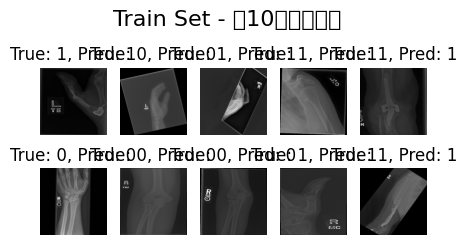

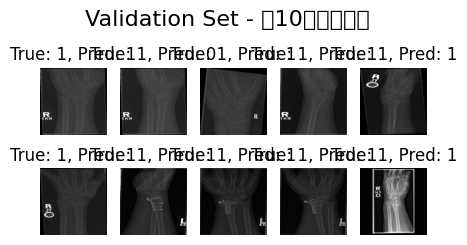

In [61]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
torch.save(model.state_dict(), "best_model_resnet_Mar20.pth")
model.eval()

def visualize_predictions(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(5, 5))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.cuda(), labels.cuda().unsqueeze(1)
            outputs = model(images)
            probs = torch.sigmoid(outputs).cpu().numpy() 
            predictions = (probs > 0.5).astype(int)  

            for i in range(len(images)):
                if images_shown >= 10:
                    break
                plt.subplot(4, 5, images_shown + 1)
                img = images[i].cpu().permute(1, 2, 0).numpy() 
                img = (img - img.min()) / (img.max() - img.min())  

                plt.imshow(img, cmap="gray")
                plt.title(f"True: {int(labels[i].item())}, Pred: {predictions[i][0]}")
                plt.axis("off")
                images_shown += 1

            if images_shown >= 10:
                break

    plt.suptitle(f"{dataset_name} - first 10 result", fontsize=16)
    plt.show()

visualize_predictions(train_loader, "Train Set")
visualize_predictions(valid_loader, "Validation Set")


In [67]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F

model = MyModel().cuda()
model.load_state_dict(torch.load("best_model_resnet_Mar20.pth"))
model.eval()
target_layer = model.model_resnet.layer4[-1]

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.target_layer.register_forward_hook(self.forward_hook)
        self.target_layer.register_backward_hook(self.backward_hook)

    def forward_hook(self, module, input, output):
        self.activations = output  

    def backward_hook(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]  

    def generate_cam(self, input_image):
        input_image = input_image.unsqueeze(0).cuda()
        self.model.zero_grad()

        output = self.model(input_image)  
        output.backward(retain_graph=True)  
        weights = self.gradients.mean(dim=[2, 3], keepdim=True) 
        cam = (weights * self.activations).sum(dim=1, keepdim=True)  
        cam = F.relu(cam) 
        cam = cam.squeeze().cpu().detach().numpy()  
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        cam = cv2.resize(cam, (224, 224)) 
        return cam
        
grad_cam = GradCAM(model, target_layer)


D:\AnaConda\envs\pytorchEnv\Lib\site-packages\torch\nn\modules\module.py:1830: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


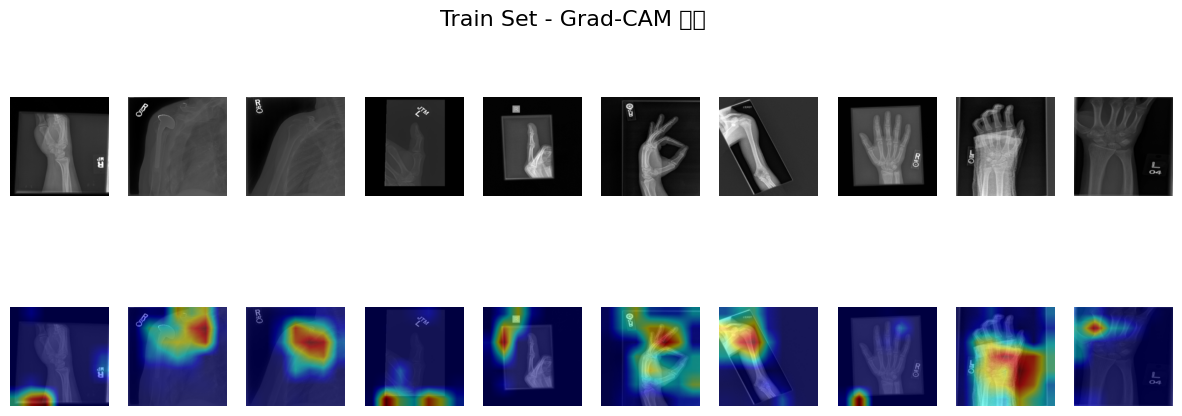

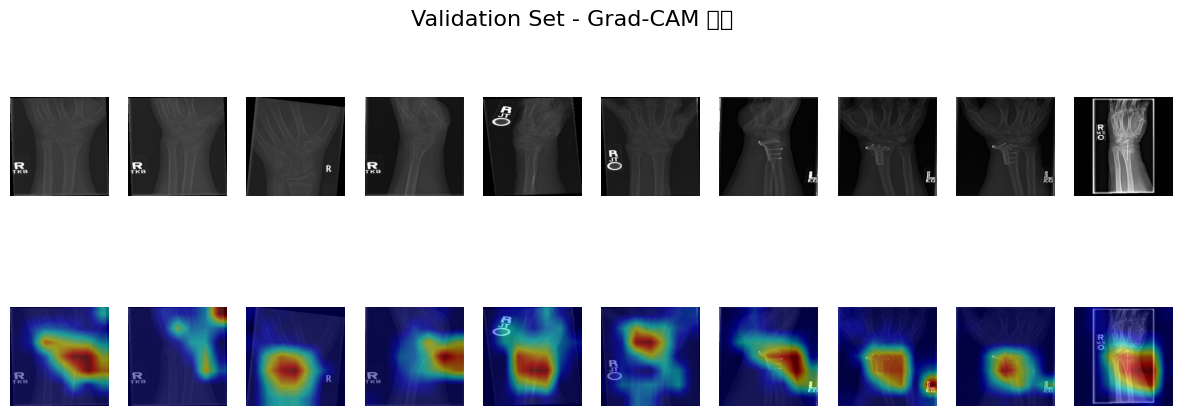

In [68]:
def visualize_cam(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break

            cam = grad_cam.generate_cam(images[i])
            img = images[i].cpu().permute(1, 2, 0).numpy()  
            img = (img - img.min()) / (img.max() - img.min())  
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = (0.5 * heatmap + 0.5 * img * 255).astype(np.uint8)
            plt.subplot(2, 10, images_shown + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")

            plt.subplot(2, 10, images_shown + 11)
            plt.imshow(overlay)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Grad-CAM ", fontsize=16)
    plt.show()

visualize_cam(train_loader, "Train Set")
visualize_cam(valid_loader, "Validation Set")


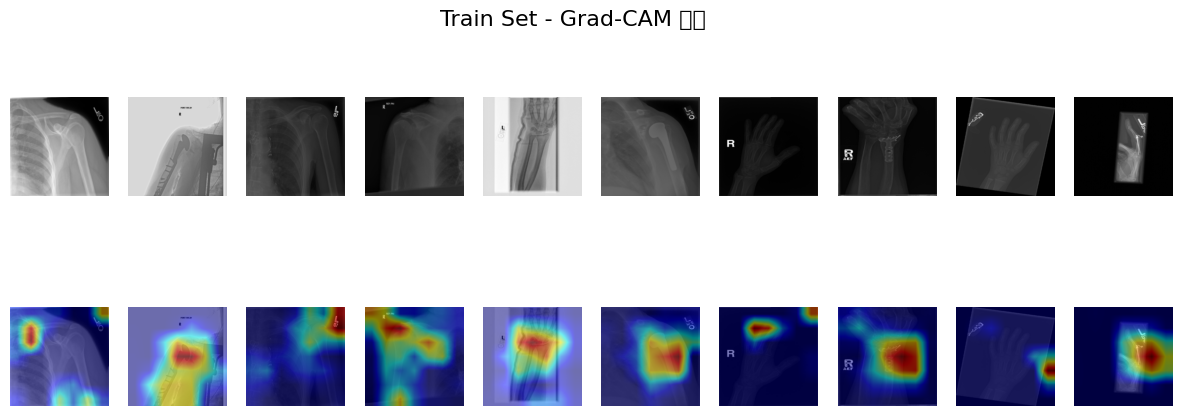

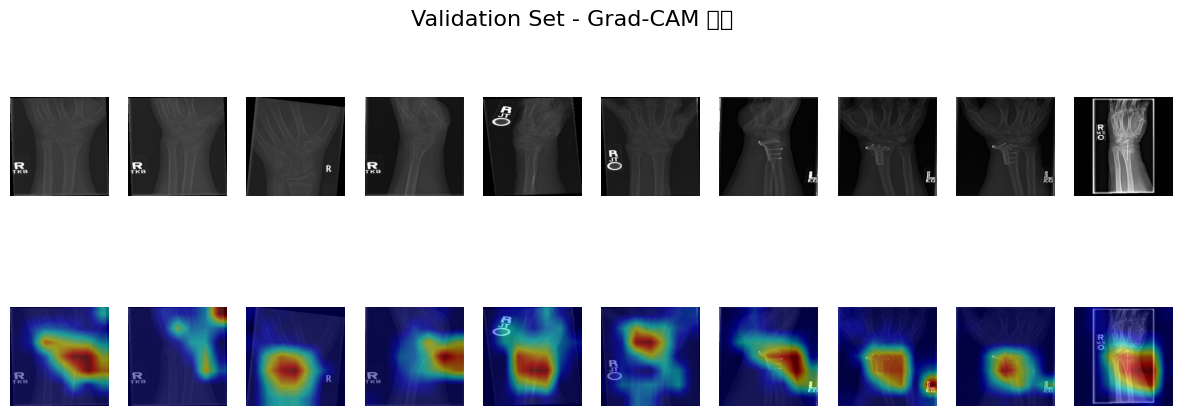

In [69]:
def visualize_cam(loader, dataset_name):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break

            cam = grad_cam.generate_cam(images[i])
            img = images[i].cpu().permute(1, 2, 0).numpy()  
            img = (img - img.min()) / (img.max() - img.min())  
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            overlay = (0.5 * heatmap + 0.5 * img * 255).astype(np.uint8)
            plt.subplot(2, 10, images_shown + 1)
            plt.imshow(img, cmap="gray")
            plt.axis("off")
            plt.subplot(2, 10, images_shown + 11)
            plt.imshow(overlay)
            plt.axis("off")
            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Grad-CAM ", fontsize=16)
    plt.show()

visualize_cam(train_loader, "Train Set")
visualize_cam(valid_loader, "Validation Set")


In [70]:
def generate_bounding_box(cam, box_size=50):

    h, w = cam.shape
    max_idx = np.unravel_index(np.argmax(cam), cam.shape)  
    center_x, center_y = max_idx[1], max_idx[0]  
    half_size = box_size // 2
    x1, y1 = max(0, center_x - half_size), max(0, center_y - half_size)
    x2, y2 = min(w, center_x + half_size), min(h, center_y + half_size)
    return (x1, y1, x2, y2), (center_x, center_y)


Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


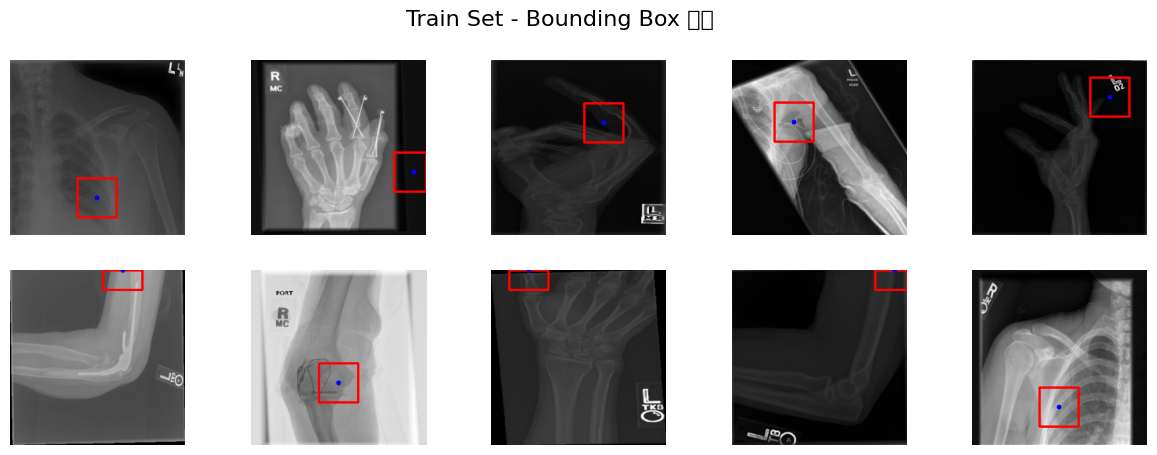

Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8
Image Shape: (224, 224, 3), dtype: uint8


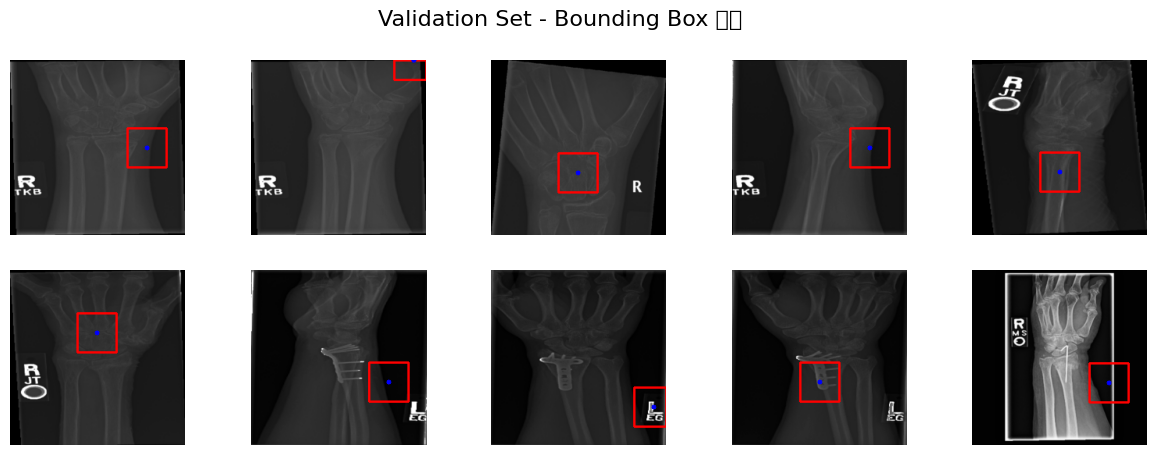

In [71]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def visualize_bbox(loader, dataset_name, box_size=50):
    images_shown = 0
    plt.figure(figsize=(15, 5))

    for images, labels in loader:
        images = images.cuda()

        for i in range(len(images)):
            if images_shown >= 10:
                break

            cam = grad_cam.generate_cam(images[i])
            bbox, center = generate_bounding_box(cam, box_size=box_size)
            img = images[i].cpu().permute(1, 2, 0).numpy()
            img = (img - img.min()) / (img.max() - img.min())  
            img = (img * 255).astype(np.uint8)  
            if img.ndim == 2:  
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            elif img.shape[-1] == 1: 
                img = np.repeat(img, 3, axis=-1)

            print(f"Image Shape: {img.shape}, dtype: {img.dtype}")
            img = np.array(img, dtype=np.uint8)  
            x1, y1, x2, y2 = bbox
            img = cv2.rectangle(img.copy(), (x1, y1), (x2, y2), (255, 0, 0), 2)  
            img = cv2.circle(img.copy(), center, 3, (0, 0, 255), -1)  
            plt.subplot(2, 5, images_shown + 1)
            plt.imshow(img)
            plt.axis("off")

            images_shown += 1

        if images_shown >= 10:
            break

    plt.suptitle(f"{dataset_name} - Bounding Box", fontsize=16)
    plt.show()

visualize_bbox(train_loader, "Train Set")
visualize_bbox(valid_loader, "Validation Set")
